# Customer Analytics exercises

In module 2, you learned about user and data flow design, data access and controls, pseudonymization and anonymization. Let's practice some of these by diving into the following exercises give your example use case.

## Non-coding exercises and prompts

1. **Privacy harm identification and analysis**: You are working on analyzing seasonal trends to populate the initial landing pages of the ecommerce store. What data might you want to analyze and what are you looking for? Can you identify any possible privacy harms or concerns with collecting or using this data?
2. **User research and design**: Once analyzed, you'd like to combine seasonal trends with other information about customers to figure out what to present to a logged in user when they come to the store. How can you communicate this data usage and collection transparently to the customers? What would an opt-out or opt-in option look like? How might you test it?
3. **User and data flow design**: Mock up a potential user and data flow with controls should you collect the data and use it. What data should be pseudonymized, redacted or anonymized? What data shouldn't ever be collected?


## Coding exercise

Walk through the exercise below and feel free to experiment with changing values or reshaping the data. When you're done, take a look at the Your Turn challenges to explore further.




In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from pyspark.sql import SparkSession
from tmlt.analytics.keyset import KeySet
from tmlt.analytics.privacy_budget import PureDPBudget
from tmlt.analytics.protected_change import AddRowsWithID, AddOneRow
from tmlt.analytics.query_builder import QueryBuilder, ColumnType, BinningSpec
from tmlt.analytics.session import Session
from tmlt.analytics.constraints import (
    MaxGroupsPerID,
    MaxRowsPerGroupPerID,
    MaxRowsPerID,
)

spark = SparkSession.builder.getOrCreate()
sales_df = spark.read.option("multiline", "true").json("data/sales.json")
sales_df.schema

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/16 11:28:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


StructType([StructField('items', ArrayType(StructType([StructField('category', StringType(), True), StructField('item', StringType(), True), StructField('item_id', LongType(), True), StructField('quantity', LongType(), True)]), True), True), StructField('membership_number', StringType(), True), StructField('sale_datetime', StringType(), True), StructField('sale_id', LongType(), True), StructField('store_id', LongType(), True), StructField('store_location', StringType(), True)])

## Flattening the dataframe for use with Tumult

Since the sales dataframe is nested, we need to flatten it in order to use Tumult, since the library only works with flat data structures. Let's quickly transform the dataframe to better fit the library. 

In [2]:
from pyspark.sql.functions import explode
sales_df = sales_df.select(sales_df.membership_number, 
                    sales_df.sale_datetime,
                    sales_df.sale_id,
                    sales_df.store_location,
                    explode(sales_df.items).alias("sale_item_details"))
sales_df = sales_df.select("*", "sale_item_details.*").drop("sale_item_details")

In [3]:
sales_df.head()

Row(membership_number='', sale_datetime='1990-03-04T03:53:32.827930', sale_id=3000, store_location='Lake Justinmouth, Iowa', category='Fish and shellfish', item='salmon', item_id=41258, quantity=1)

### Starting a Differential Privacy Session with a Budget

First, we are going to set a budget for the queries. We'll choose a fairly relaxed initial budget of 2.5 -- you can learn more about choosing budgets via [Tumult's documentation](https://docs.tmlt.dev/analytics/latest/tutorials/privacy-budget-basics.html) or picking up a copy of [my book](https://practicaldataprivacybook.com/)!



In [4]:
session = Session.from_dataframe(
    privacy_budget=PureDPBudget(epsilon=2.5),
    source_id="sales",
    dataframe=sales_df,
    protected_change=AddOneRow(),
)

In [5]:
categories = [x.category for x in sales_df.select("category").distinct().collect()]

In [6]:
categories

['Health Care',
 'Meat and Animal Products',
 'Cereal',
 'Other items',
 'Fish and shellfish',
 'Condiments & Spices',
 'Vegetables',
 'Baby Items',
 'Beverages',
 'Paper & Wrap',
 'Dairy',
 'Vegetarian and Vegan Alternatives',
 'Personal Care',
 'Bread & Bakery',
 'Deli',
 'Pasta/Rice',
 'Household Supplies',
 'Canned Goods',
 'Sauces & Oils',
 'Fruits',
 'Frozen Foods',
 'Snacks',
 'Baking']

In [7]:
category_keyset = KeySet.from_dict({
    "category": categories
})


In [8]:
category_sales_query = (    
    QueryBuilder("sales")
    .groupby(category_keyset)
    .count()     
    .suppress(1)
)

In [9]:
category_counts = session.evaluate(
    category_sales_query,
    PureDPBudget(0.2)
)

/opt/miniconda3/envs/book/lib/python3.12/site-packages/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


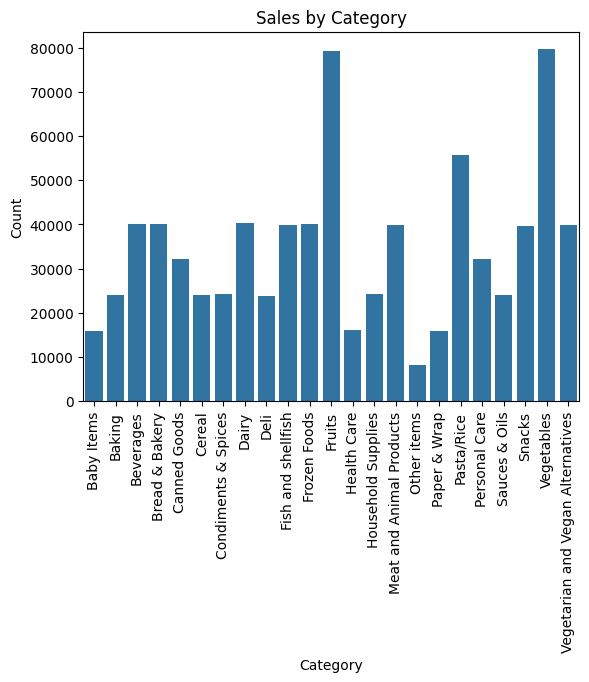

In [10]:
sns.barplot(
    x="category",
    y="count",
    data=category_counts.toPandas().sort_values("category"),
)
plt.title("Sales by Category")
plt.xlabel("Category")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.show()

### Your Turn! A quick exercise

- Take a look at the most popular items, by first developing a keyset and then creating a count histogram. This time, filter by a particular store! (Hint: try using a where query!)
- We only grouped in this exercise so far by protecting an item-by-item purchase. See if you can instead either protect by purchase ID or membership ID using [this tutorial.](https://docs.tmlt.dev/analytics/latest/tutorials/privacy-id-basics.html#creating-a-session-with-privacy-ids)
- We actually didn't look at the full forecast, since that is the quantity + the category. Can you calculate that by using the quantity and instead of using count use the quantity? Should you cap the quantity contribution of each row or member?